# <span style="color:slateblue"><b>Dependencies Import

In [ ]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import scipy.stats as sp
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import itertools
from imblearn.ensemble import BalancedRandomForestClassifier


import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import cross_val_predict

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

from sklearn.cluster import AgglomerativeClustering
import hvplot.pandas
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
pd.options.display.max_columns = 999

# <span style="color:slateblue"><b>Data Load</span>

In [ ]:
from sqlalchemy import create_engine

userID='postgres'
password='toThaStars1!'
endpoint='kepler-exoplanet.cotbxoedtrfv.us-east-1.rds.amazonaws.com'
port='5432'
dbinstance='kepler-exoplanet'
dbinstance='kepler-damien'


db_string = f"postgres://{userID}:{password}@{endpoint}:{port}/{dbinstance}"
print(db_string)

engine = create_engine(db_string)
print(engine)

In [ ]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
# We can view all of the classes that automap found
Base.classes.keys()

In [ ]:
# Save references to each table
Raw_Data = Base.classes.raw_kepler

In [ ]:
# Reflect to see all the tables and respective columns
from sqlalchemy import inspect
inspector = inspect(engine)

for table_name in inspector.get_table_names():
   print("Table Name: %s" % table_name)
   for column in inspector.get_columns(table_name):
       print("Column: %s" % column['name'])

In [ ]:
# Reading the output from in tspect here is one table, load that table into a data frame. 

keplerRAW_df = pd.read_sql_table('raw_kepler', engine) 
keplerRAW_df

# <span style="color:slateblue"><b>EDA & Preprocessing

In [ ]:
keplerRAW_df.info()

In [ ]:
keplerRAW_df.describe()

### <span style="color:red">need to update with the new names

In [ ]:
# The default index adds no value, however the "kepoi_name" is the unique identified for each object of interest (row).
# We make this the index to preserve the relationship through the processing

# change the index to the "kepoi_name" and drop the index title
keplerProcessed_df = keplerRAW_df.set_index('kepoi_name')
keplerProcessed_df.rename_axis(None, inplace=True)

keplerProcessed_df 

In [ ]:
# Find and drop err columns
columns_to_drop = [col for col in keplerProcessed_df.columns if '_err' in col]

keplerProcessed_df = keplerProcessed_df.drop(columns=columns_to_drop)
keplerProcessed_df

In [ ]:
# Rename columns to improve legibility
keplerProcessed_df.rename(columns={'kepid' : 'Kep ID',
                               'kepoi_name' : 'KOI Name',
                                'kepler_name' : 'Kepler Name',
                                'koi_disposition' : 'Exoplanet Archive Disposition',
                                'koi_pdisposition' : 'Disposition Using Kepler Data',
                                'koi_score' : 'Disposition Score',
                                'koi_fpflag_nt' : 'Not Transit-Like FPF',
                                'koi_fpflag_ss' : 'Stellar Eclipse FPF',
                                'koi_fpflag_co' : 'Centroid Offset FPF',
                                'koi_fpflag_ec' : 'Ephemeris Match Indicates Contamination FPF',
                                'koi_period' : 'Orbital Period [days]',
                                'koi_time0bk' : 'Transit Epoch [BKJD]',
                                'koi_impact' : 'Impact Parameter',
                                'koi_duration' : 'Transit Duration [hrs]',
                                'koi_depth' : 'Transit Depth [ppm]',
                                'koi_prad' : 'Planetary Radius [Earth radii]',
                                'koi_teq' : 'Equilibrium Temperature [K]',
                                'koi_insol' : 'Insolation Flux [Earth flux]',
                                'koi_model_snr' : 'Transit Signal-to-Noise',
                                'koi_tce_plnt_num' : 'TCE Planet Number',
                                'koi_tce_delivname' : 'TCE Delivery',
                                'ra' : 'RA [decimal degrees]',
                                'dec' : 'Dec [decimal degrees]',
                                'koi_kepmag' : 'Kepler-band [mag]'}, inplace = True)
keplerProcessed_df

In [ ]:
# Drop columns that do not add value to the model. These include unneeded labels

# koi_disposition and koi_score both have a high correlation to the target(y). Drop them
keplerProcessed_df.drop(["rowid","Kep ID","Kepler Name","Disposition Using Kepler Data", "Disposition Score"], axis =1, inplace=True)

In [ ]:
# Convert koi_tce_delivname to numeric dummies
# This feature only has (3) values. We convert to dummies to include in the models
keplerProcessed_df = pd.get_dummies(keplerProcessed_df, columns=["TCE Delivery"])

### <span style="color:red">NOTE: Using the koi_pdisposition for simplification since it has (2) values. Lets look at what it takes to use koi_disposition instead (has 4 values)</span>

In [ ]:
# Convert koi_pdisposition to numeric, this will be the "target"
le = LabelEncoder()

keplerProcessed_df['Exoplanet Archive Disposition'] = le.fit_transform(keplerProcessed_df['Exoplanet Archive Disposition'])
keplerProcessed_df

### <span style="color:orange">Processing of missing values (Nulls)

In [ ]:
keplerProcessed_df.isnull().sum().sum()

In [ ]:
count_nan_in_df = keplerProcessed_df.isnull().sum()
print (count_nan_in_df)

In [ ]:
# Drop rows with NaN
keplerProcessedDropNull_df = keplerProcessed_df.copy(deep=True)
keplerProcessedDropNull_df = keplerProcessedDropNull_df.dropna()
keplerProcessedDropNull_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Mean
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

keplerProcessedMeanImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedMeanImpute_df.iloc[:,:] = imputer_mean.fit_transform(keplerProcessedMeanImpute_df)
keplerProcessedMeanImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Median
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')

keplerProcessedMedianImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedMedianImpute_df.iloc[:,:] = imputer_median.fit_transform(keplerProcessedMedianImpute_df)
keplerProcessedMedianImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Mode
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

keplerProcessedModeImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedModeImpute_df.iloc[:,:] = imputer_mode.fit_transform(keplerProcessedMeanImpute_df)
keplerProcessedModeImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via MICE
# Multivariate Imputation By Chained Equations


### <span style="color:red"> Adjust the keplerProcessed_df based on the impute method being tested
    - CURRENT METHOD: "dropping"

In [ ]:
# Based on the Impute method being tested

del keplerProcessed_df

keplerProcessed_df = keplerProcessedDropNull_df
#keplerProcessed_df = keplerProcessedMeanImpute_df
#keplerProcessed_df = keplerProcessedMedianImpute_df
#keplerProcessed_df = keplerProcessedModeImpute_df

keplerProcessed_df.isnull().sum().sum()

### Analyze column variance 

In [ ]:
keplerProcessed_df.var()

In [ ]:
#Selecting only numeric columns
num_columns = keplerProcessed_df.dtypes[keplerProcessed_df.dtypes != "object"].index.tolist()
variance_df = keplerProcessed_df[num_columns]

# Check mean and standard deviation
stats_df = variance_df.describe().loc[['mean', 'std']]

# Transpose the dataframe
stats_df = stats_df.T

# Add standard deviation ratios 
stats_df["ratio"]=stats_df["std"]/stats_df["mean"]
stats_df = stats_df.sort_values("ratio", ascending=False)
stats_df

In [ ]:
# Plot the standard deviation ratios columns
ax = stats_df.plot(y = "ratio", 
                   kind = "bar", 
                   figsize = (20,5), 
                   title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)", 
                   fontsize=14)

### Covariance Matrix - (long runtime)

In [ ]:
#covMatrix = np.cov(keplerProcessed_df,bias=True)

#fig_covMatrix = px.imshow(covMatrix)
#fig_covMatrix.show()

### Correlation Matrix

In [ ]:
keplerCorrMatrix = keplerProcessed_df.corr()
#print(keplerCorrMatrix) 

In [ ]:
 # Generate a mask for the upper triangle
corr_mask = np.zeros_like(keplerCorrMatrix)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(10,10))

# Plot heatmap of annotated correlations; change background to white
# uses seaborn
with sn.axes_style('white'):
    sn.heatmap(keplerCorrMatrix*100, 
                cmap='RdBu_r', 
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)
    
plt.title('Correlations', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, horizontalalignment='right')
#plt.xticks(rotation=45)
plt.show()

In [ ]:
fig_corrMatrix = px.imshow(keplerCorrMatrix, width=600, height=600)
fig_corrMatrix.update_yaxes(automargin=True)
fig_corrMatrix.show()

In [ ]:
# Correlation matrix on selected features
keplerCorrMatrix = keplerProcessed_df.corr()

### Feature select

<span style="color:orange"><b>Feature Importance graph for all features. Use to aid feature selection<br>
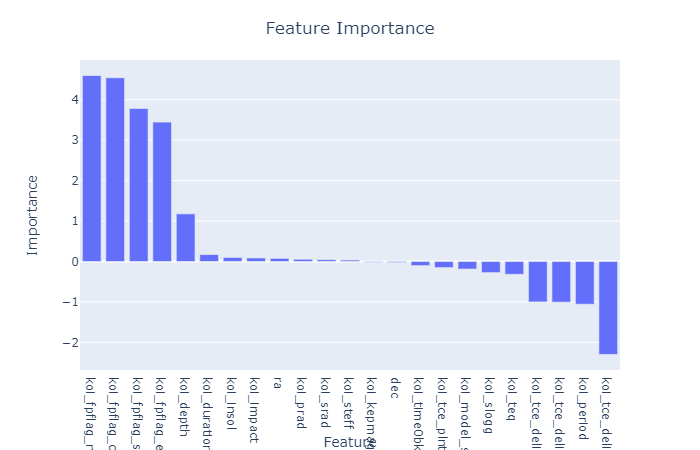

In [ ]:
# Reduce feature set based on feature importance results
keplerProcessed_df = keplerProcessed_df[["Exoplanet Archive Disposition","Not Transit-Like FPF","Stellar Eclipse FPF","Centroid Offset FPF","Ephemeris Match Indicates Contamination FPF",'Impact Parameter','Transit Depth [ppm]','Planetary Radius [Earth radii]','Transit Signal-to-Noise']]
keplerProcessed_df

In [ ]:
keplerProcessed_df.info()

# <span style="color:slateblue"><b>Visualizations

In [ ]:
confirmed = keplerRAW_df[keplerRAW_df.koi_disposition == 'CONFIRMED']

In [ ]:
fig = plt.figure(figsize=(12, 12))

plt.scatter(keplerRAW_df.ra, keplerRAW_df.dec, s=3, label='Candidates')
plt.scatter(confirmed.ra, confirmed.dec, s=3, label="Confirmed")

plt.xlabel("Right Ascension")
plt.ylabel("Declination")

plt.legend()

In [ ]:
FOV_plot = px.scatter(keplerRAW_df,
                  x="ra", 
                  y="dec", 
                  color = "koi_disposition",
                  labels={
                     "ra": "Right Ascension",
                     "dec": "Declination",
                  },
                  template="plotly_dark",
                  width=1000, height=800
                 )
FOV_plot.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 35,
        dtick = 2
    )
)
#FOV_plot.add_trace(go.Scatter(y=[None], mode='markers',
#                         marker=dict(symbol='circle', color='blue'),

#                         ))
#FOV_plot.add_trace(go.Scatter(y=[None], mode='markers',
#                         marker=dict(symbol='circle', color='green'),

#                         ))

FOV_plot.show()

# ******Gabe suggestion - add density plots? to highlighting why each area may be more dense

# <span style="color:red"><b> Sequential Feature Selection results

### True

### FALSE

### using disposition instead of pdisposition